In [1]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
# !pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.7 MB/s eta 0:00:00


In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [3]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteOPTKFZ/ted_hrlr_translate-trai…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteOPTKFZ/ted_hrlr_translate-vali…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0.incompleteOPTKFZ/ted_hrlr_translate-test…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_examples, val_examples = examples['train'], examples['validation']

**Examples in Portuguese and English**

In [5]:
for pt_examples, en_examples in train_examples.batch(3).take(1):
  for pt in pt_examples.numpy():
    print(pt.decode('utf-8'))
  for en in en_examples.numpy():
    print(en.decode('utf-8'))

e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
mas e se estes fatores fossem ativos ?
mas eles não tinham a curiosidade de me testar .
and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


Lets setup the Tokenizer


In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'
tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir = '.', cache_subdir = '', extract = True
)

184801/184801 [==============================] - 0s 0us/step


'./ted_hrlr_translate_pt_en_converter.zip'

In [7]:
tokenizers = tf.saved_model.load(model_name)

In [8]:
[item for item in dir(tokenizers.en) if not item.startswith('_')]

['detokenize',
 'get_reserved_tokens',
 'get_vocab_path',
 'get_vocab_size',
 'lookup',
 'tokenize',
 'tokenizer',
 'vocab']

In [9]:
for en in en_examples:
  print(en.numpy().decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n't test for curiosity .


In [10]:
tokens = tokenizers.en.tokenize(en_examples)

for tk in tokens.to_list():
  print(tk)

[2, 72, 117, 79, 1259, 1491, 2362, 13, 79, 150, 184, 311, 71, 103, 2308, 74, 2679, 13, 148, 80, 55, 4840, 1434, 2423, 540, 15, 3]
[2, 87, 90, 107, 76, 129, 1852, 30, 3]
[2, 87, 83, 149, 50, 9, 56, 664, 85, 2512, 15, 3]


In [11]:
de_tokenized = tokenizers.en.detokenize(tokens)

for dtk in de_tokenized.numpy():
  print(dtk.decode('utf-8'))

and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
but what if it were active ?
but they did n ' t test for curiosity .


In [12]:
de_tokens = tokenizers.en.lookup(tokens)
de_tokens

<tf.RaggedTensor [[b'[START]', b'and', b'when', b'you', b'improve', b'search', b'##ability',
  b',', b'you', b'actually', b'take', b'away', b'the', b'one', b'advantage',
  b'of', b'print', b',', b'which', b'is', b's', b'##ere', b'##nd', b'##ip',
  b'##ity', b'.', b'[END]']                                                 ,
 [b'[START]', b'but', b'what', b'if', b'it', b'were', b'active', b'?',
  b'[END]']                                                           ,
 [b'[START]', b'but', b'they', b'did', b'n', b"'", b't', b'test', b'for',
  b'curiosity', b'.', b'[END]']                                          ]>

Set up a data pipeline

In [13]:
MAX_TOKENS = 128
def prepare_batch(pt, en):
  en = tokenizers.en.tokenize(en)
  en = en[:, : MAX_TOKENS]
  en = en.to_tensor()

  pt = tokenizers.pt.tokenize(pt)
  pt = pt[:, :(MAX_TOKENS+1)]
  pt_inputs = pt[:, : -1].to_tensor()
  pt_labels = pt[:, 1:].to_tensor()

  return (en, pt_inputs), pt_labels

# MAX_TOKENS = 128
# def prepare_batch(pt, en):
#   pt = tokenizers.pt.tokenize(pt)
#   pt = pt[:, : MAX_TOKENS]
#   pt = pt.to_tensor()

#   en = tokenizers.en.tokenize(en)
#   en = en[:, :(MAX_TOKENS+1)]
#   en_inputs = en[:, : -1].to_tensor()
#   en_labels = en[:, 1:].to_tensor()

#   return (pt, en_inputs), en_labels


In [14]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [15]:
def make_batches(ds):
  return (ds
          .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
          .map(prepare_batch, tf.data.AUTOTUNE)
          .prefetch(buffer_size = tf.data.AUTOTUNE))

Create training and validation set batches

In [16]:
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

In [17]:
for (en, pt), pt_labels in train_batches.take(1):
  break

print(en.shape)
print(pt.shape)
print(pt_labels.shape)

(64, 79)
(64, 77)
(64, 77)


In [18]:
print(pt[0][:10])
print(pt_labels[0][:10])
print(en[0][:10])

tf.Tensor([   2   44  100  142 1277   16   54 2366   14  151], shape=(10,), dtype=int64)
tf.Tensor([  44  100  142 1277   16   54 2366   14  151   93], shape=(10,), dtype=int64)
tf.Tensor([   2   72   92   99  680 5558  677  459 2796   13], shape=(10,), dtype=int64)


In [19]:
def positional_encoding(length, depth):
  depth = depth/2
  positions = np.arange(length)[:, np.newaxis]

  depths = np.arange(depth)[np.newaxis, :]/depth

  angle_rates = 1 / (10000**depths)
  angle_rads = positions * angle_rates

  pos_encoding = np.concatenate([np.sin(angle_rads), 
                                np.cos(angle_rads)],
                                axis = -1)
  return tf.cast(pos_encoding, dtype = tf.float32)

create a PositionEmbedding layer that looks-up a token's embedding vector and adds the position vector

In [20]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size,
                                               d_model, mask_zero = True)
    self.pos_encoding = positional_encoding(length = 2048, depth = d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)
  
  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [21]:
embed_pt = PositionalEmbedding(vocab_size = tokenizers.pt.get_vocab_size(),
                               d_model = 512)
embed_en = PositionalEmbedding(vocab_size = tokenizers.en.get_vocab_size(),
                               d_model = 512)

pt_emb = embed_pt(pt)
en_emb = embed_en(en)

In [22]:
en_emb._keras_mask

<tf.Tensor: shape=(64, 79), dtype=bool, numpy=
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])>

** The Base Attention Layer:**
  Attention layers are used throughout the model. These are all identical except for how the attention is configured. Each one contains a layers.MultiHeadAttention, a layers.LayerNormalization and a layers.Add.

In [23]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

The cross attention layer

In [24]:
class CrossAttention(BaseAttention):
  def call(self, x, context):
    attn_output, attn_scores = self.mha(
        query = x,
        key = context,
        value = context,
        return_attention_scores = True
    )
    self.last_attn_scores = attn_scores
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

Global self attention Layer

In [25]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        key = x,
        value = x
    )
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [26]:
test_gsa = GlobalSelfAttention(num_heads = 2, key_dim = 512)

print(pt_emb.shape)
print(en_emb.shape)
print(test_gsa(pt_emb).shape)
print(test_gsa(en_emb).shape)

(64, 77, 512)
(64, 79, 512)
(64, 77, 512)
(64, 79, 512)


Casual Self Attention

In [27]:
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query = x,
        key = x,
        value = x,
        use_causal_mask = True
    )
    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [28]:
test_csa = CausalSelfAttention(num_heads = 2, key_dim = 512)

print(pt_emb.shape)
print(en_emb.shape)
print(test_csa(pt_emb).shape)
print(test_csa(en_emb).shape)

(64, 77, 512)
(64, 79, 512)
(64, 77, 512)
(64, 79, 512)


The Feed forward Network

In [29]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate = 0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation = 'relu'),
        tf.keras.layers.Dense(d_model),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
      x = self.add([x, self.seq(x)])
      x = self.layer_norm(x)

      return x

In [30]:
test_ffn = FeedForward(512, 2048)
print(en_emb.shape)
print(test_ffn(en_emb).shape)

(64, 79, 512)
(64, 79, 512)


The encoder layer

In [31]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, *, d_model, num_heads, dff, dropout_rate = 0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )
    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
      x = self.self_attention(x)
      x = self.ffn(x)
      return x

In [32]:
testing_encoder_layer = EncoderLayer(d_model = 512,num_heads =  6,dff=  2048)

print(en_emb.shape)
print(testing_encoder_layer(en_emb).shape)

(64, 79, 512)
(64, 79, 512)


Now lets combine the PositionalEmbedding and EncoderLayer to build the encoder

In [33]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size, dropout_rate = 0.1):
    super().__init__()
    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size = vocab_size, d_model = d_model
    )
    self.enc_layers = [
        EncoderLayer(d_model = d_model,
                     num_heads = num_heads,
                     dff = dff,
                     dropout_rate = dropout_rate
    )
        for _ in range(num_layers)
    ]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
  
  def call(self, x):

    x = self.pos_embedding(x)
    x = self.dropout(x)
    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x

  

In [34]:
# Instantiate the encoder.
sample_encoder = Encoder(num_layers=4,
                         d_model=512,
                         num_heads=8,
                         dff=2048,
                         vocab_size=8500)

sample_encoder_output = sample_encoder(en, training=False)

# Print the shape.
print(en.shape)
print(sample_encoder_output.shape)  # Shape `(batch_size, input_seq_len, d_model)`.

(64, 79)
(64, 79, 512)


Now lets code Decoder, it contains CasualSelfAttention, CrossAttention and FeedForward

In [35]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate = 0.1):
    super(DecoderLayer, self).__init__()

    self.causal_self_attention = CausalSelfAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )

    self.cross_attention = CrossAttention(
        num_heads = num_heads,
        key_dim = d_model,
        dropout = dropout_rate
    )

    self.ffn = FeedForward(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x = x)
    x = self.cross_attention(x = x, context = context)

    self.last_attn_scores = self.cross_attention.last_attn_scores
    x = self.ffn(x)
    return x

In [36]:
initiating_decoder_layer = DecoderLayer(d_model = 512,
                                        num_heads = 8,
                                        dff = 2048)
initiating_decoder_layer_output = initiating_decoder_layer(x = pt_emb, context = en_emb)

print(pt_emb.shape)
print(en_emb.shape)
print(initiating_decoder_layer_output.shape)

(64, 77, 512)
(64, 79, 512)
(64, 77, 512)


The Decoder: It consists of PositionalEmbedding and a stack of DecoderLayers

In [37]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
               dropout_rate = 0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(vocab_size = vocab_size,
                                             d_model = d_model)
    
    self.dropout = tf.keras.layers.Dropout(dropout_rate)
    self.dec_layers = [
        DecoderLayer(d_model = d_model, num_heads = num_heads,
                     dff = dff, dropout_rate = dropout_rate)
        for _ in range(num_layers)
    ]
    self.last_attn_scores = None
  def call(self, x, context):
    x = self.pos_embedding(x)
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.dec_layers[i](x, context)
    
    self.last_attn_scores = self.dec_layers[-1].last_attn_scores

    return x

In [38]:
testing_decoder = Decoder(
    num_layers = 4,
    d_model = 256,
    num_heads = 8,
    dff = 1536,
    vocab_size = 6000
)
decoder_output = testing_decoder(x = pt, context = en_emb)

print(pt.shape)
print(en_emb.shape)
print(decoder_output.shape)

(64, 77)
(64, 79, 512)
(64, 77, 256)


In [39]:
testing_decoder.last_attn_scores.shape

TensorShape([64, 8, 77, 79])

The Transformer

In [40]:
class Transformer(tf.keras.Model):
  def __init__(self, *, num_layers, d_model, num_heads, dff,
        input_vocab_size, target_vocab_size, dropout_rate = 0.1):
    super().__init__()
    self.encoder = Encoder(num_layers = num_layers, d_model = d_model,
                           num_heads = num_heads, dff = dff,
                           vocab_size = input_vocab_size,
                           dropout_rate = dropout_rate)
    
    self.decoder = Decoder(num_layers = num_layers, d_model = d_model,
                           num_heads = num_heads, dff = dff,
                           vocab_size = target_vocab_size,
                           dropout_rate = dropout_rate)
    
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs):

    context, x = inputs
    context = self.encoder(context)

    x = self.decoder(x, context)

    logits = self.final_layer(x)

    try:
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

Hyper Parameters

In [41]:
num_layers = 4
d_model = 256
dff = 1024
num_heads = 8
dropout_rate = 0.1

Initiate the transformer

In [42]:
transformer = Transformer(
    num_layers = num_layers,
    d_model = d_model,
    dff = dff,
    num_heads = num_heads,
    input_vocab_size = tokenizers.en.get_vocab_size().numpy(),
    target_vocab_size = tokenizers.pt.get_vocab_size().numpy(),
    dropout_rate = dropout_rate
)

In [43]:
output = transformer((en, pt))

print(pt.shape)
print(en.shape)
print(output.shape)

(64, 77)
(64, 79)
(64, 77, 7765)


In [44]:
attn_scores = transformer.decoder.dec_layers[-1].last_attn_scores
print(attn_scores.shape)

(64, 8, 77, 79)


Printing the summary of the transformer model

In [45]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  12315136  
                                                                 
 decoder_1 (Decoder)         multiple                  20924672  
                                                                 
 dense_38 (Dense)            multiple                  1995605   
                                                                 
Total params: 35,235,413
Trainable params: 35,235,413
Non-trainable params: 0
_________________________________________________________________


**Training**

Set up the optimizer

In [46]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [47]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

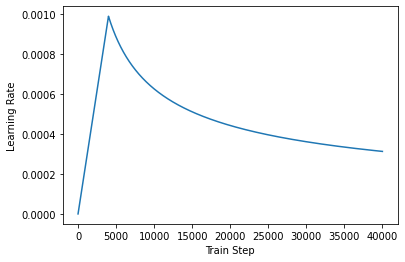

In [48]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [49]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

Train the model

In [50]:
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [51]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [52]:
transformer.fit(train_batches,
                epochs=20,
                validation_data=val_batches)

Epoch 1/20
810/810 [==============================] - 493s 552ms/step - loss: 6.4905 - masked_accuracy: 0.1564 - val_loss: 4.9956 - val_masked_accuracy: 0.2554
Epoch 2/20
810/810 [==============================] - 433s 534ms/step - loss: 4.5530 - masked_accuracy: 0.2886 - val_loss: 3.9309 - val_masked_accuracy: 0.3493
Epoch 3/20
810/810 [==============================] - 429s 530ms/step - loss: 3.6926 - masked_accuracy: 0.3741 - val_loss: 3.2900 - val_masked_accuracy: 0.4259
Epoch 4/20
810/810 [==============================] - 436s 538ms/step - loss: 3.0729 - masked_accuracy: 0.4436 - val_loss: 2.8016 - val_masked_accuracy: 0.4837
Epoch 5/20
810/810 [==============================] - 432s 532ms/step - loss: 2.6986 - masked_accuracy: 0.4870 - val_loss: 2.6123 - val_masked_accuracy: 0.5063
Epoch 6/20
810/810 [==============================] - 431s 532ms/step - loss: 2.4076 - masked_accuracy: 0.5244 - val_loss: 2.3536 - val_masked_accuracy: 0.5426
Epoch 7/20
810/810 [====================

In [53]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # The input sentence is English, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.en.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is Portuguese, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.pt.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.pt.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.pt.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    return text, tokens, attention_weights

In [54]:
translator = Translator(tokenizers, transformer)

In [55]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print(f'{"Ground truth":15s}: {ground_truth}')

In [56]:
ground_truth = 'este é um problema que temos que resolver.'
sentence = 'this is a problem we have to solve .'

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : this is a problem we have to solve .
Prediction     : isto e um problema que temos de resolver .
Ground truth   : este é um problema que temos que resolver.


In [57]:
class ExportTranslator(tf.Module):
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [58]:
translator = ExportTranslator(translator)

In [59]:
translator('this is the first book i did.').numpy()

b'foi o primeiro livro que fiz .'

In [60]:
tf.saved_model.save(translator, export_dir='Trained_transformer')

In [63]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)

In [62]:
%cp -r /content/Trained_transformer /content/drive/MyDrive/TranslationUsingTransformers

In [76]:
reloaded = tf.saved_model.load('Trained_transformer')

In [79]:
reloaded('Hello how are you').numpy()

b'ola , como voces sao voces .'

In [99]:
reloaded("Let's test this model").numpy()

b'vamos testar este modelo .'

In [100]:
reloaded("This is really exciting!").numpy()

b'isto e muito empolgante !'

In [101]:
reloaded("Making this model was a pain.").numpy()

b'fazer este modelo foi uma dor .'

In [102]:
reloaded("Thank you!").numpy()

b'obrigada !'